In [1]:
import sys
import os
import pandas as pd
import scanpy as sc
from scipy import sparse
import numpy as np
import matplotlib.pyplot as plt
import squidpy as sq
import spatialdm as sdm
import seaborn as sns

In [2]:
from copulacci import spatial
from copulacci import model2
from copulacci import model

In [3]:
!pwd

/n/fs/ragr-research/users/hirak/Projects/copulacci/notebook/examples/seqfishplus-mouse-sscortex


In [4]:
import importlib

In [5]:
importlib.reload(spatial)

<module 'copulacci.spatial' from '/n/fs/ragr-data/users/hirak/environments/mambaforge/envs/copulacci/lib/python3.9/site-packages/copulacci/spatial.py'>

In [6]:
def linearize_to_df(cop_df_diff_gpairs, filter_copula=True):
    df = pd.DataFrame()
    for gpair in cop_df_diff_gpairs:
        tmp = cop_df_diff_gpairs[gpair].copy()
        if filter_copula:
            tmp = tmp.loc[tmp.copula_method == 'copula',:].copy()
        tmp.loc[:,'interaction'] = gpair
        tmp.loc[:,'LR_index'] = tmp.index
        tmp.index = list(range(tmp.shape[0]))
        df = pd.concat([df, tmp], axis = 0, ignore_index=True)
    return df

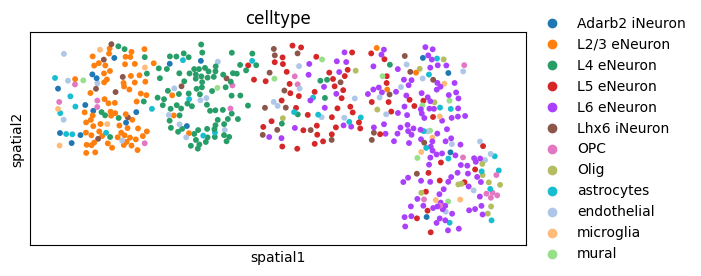

In [7]:
sp_datadir = './data/original_data'
X = sparse.load_npz(sp_datadir+'/expression.npz')
genes = list( np.loadtxt(sp_datadir+'/genes.txt', dtype=str) )
pts = np.loadtxt( sp_datadir+'/positions.csv' )
adata_sp = sc.AnnData(X=X, var=pd.DataFrame(index=genes))
adata_sp.obsm['spatial'] = pts
df_celltype = pd.read_csv('./data/celltype_annotation.csv', index_col=0)
celltypes = list(df_celltype.values.reshape(-1))
adata_sp.obs['celltype'] = pd.Series(list(celltypes), dtype="category").values
sc.pl.spatial(adata_sp, color='celltype', spot_size=100)

In [12]:
adata_sp.raw = adata_sp.copy()

In [13]:
adata_sp.write_h5ad(
    'data/seqfish_mouse_cortex.h5ad'
)

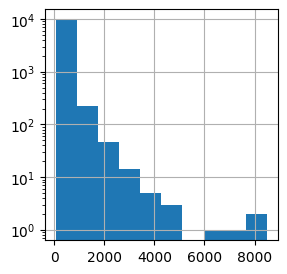

In [15]:
plt.figure(figsize=(3,3))
adata_sp.to_df().sum().hist();
plt.yscale('log')

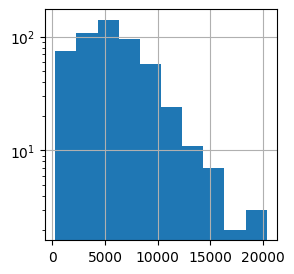

In [16]:
plt.figure(figsize=(3,3))
adata_sp.to_df().sum(1).hist();
plt.yscale('log')

In [17]:
adata_sp.raw = adata_sp.copy()

In [18]:
sc.pp.normalize_total(adata_sp, inplace=True)
sc.pp.log1p(adata_sp)

In [19]:
adata_sp.obs.celltype.value_counts()

celltype
L6 eNeuron        124
L4 eNeuron         96
L2/3 eNeuron       74
L5 eNeuron         64
endothelial        33
astrocytes         31
Lhx6 iNeuron       29
Adarb2 iNeuron     18
OPC                18
Olig               15
microglia          11
mural              10
Name: count, dtype: int64

In [13]:
sq.gr.spatial_neighbors(adata_sp, n_neighs=6, coord_type='generic')

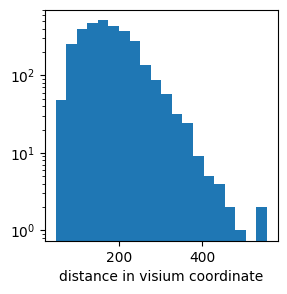

In [14]:
dist_array_flat = adata_sp.obsp['spatial_distances'].toarray().flatten()
# Remove zeros to avoid inflation
dist_array_flat = dist_array_flat[ dist_array_flat > 0 ]
plt.figure(figsize=(3,3))
plt.hist(dist_array_flat,bins=20);
plt.xlabel('distance in visium coordinate')
plt.yscale('log');

In [15]:
sq.gr.spatial_neighbors(adata_sp, radius=100, coord_type='generic')

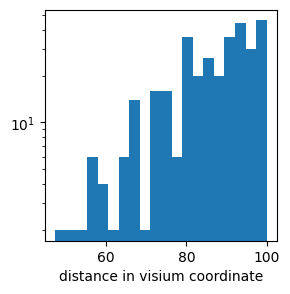

In [16]:
dist_array_flat = adata_sp.obsp['spatial_distances'].toarray().flatten()
# Remove zeros to avoid inflation
dist_array_flat = dist_array_flat[ dist_array_flat > 0 ]
plt.figure(figsize=(3,3))
plt.hist(dist_array_flat,bins=20);
plt.xlabel('distance in visium coordinate')
plt.yscale('log');

In [20]:
importlib.reload(spatial)

<module 'copulacci.spatial' from '/n/fs/ragr-data/users/hirak/environments/mambaforge/envs/copulacci/lib/python3.9/site-packages/copulacci/spatial.py'>

In [21]:
spatial_params = spatial.SpatialParams()
spatial_params = spatial_params._replace(data_type='other',radius=250, coord_type='generic')
int_edges_new, int_edges_with_selfloop = spatial.construct_boundary(
    adata_sp,
    force_recalculate=True,
    distance_aware=True,
    spatial_params=spatial_params
)

Constructing spatial network with other


100%|██████████| 523/523 [00:00<00:00, 4346.12it/s]


<Axes: xlabel='interaction'>

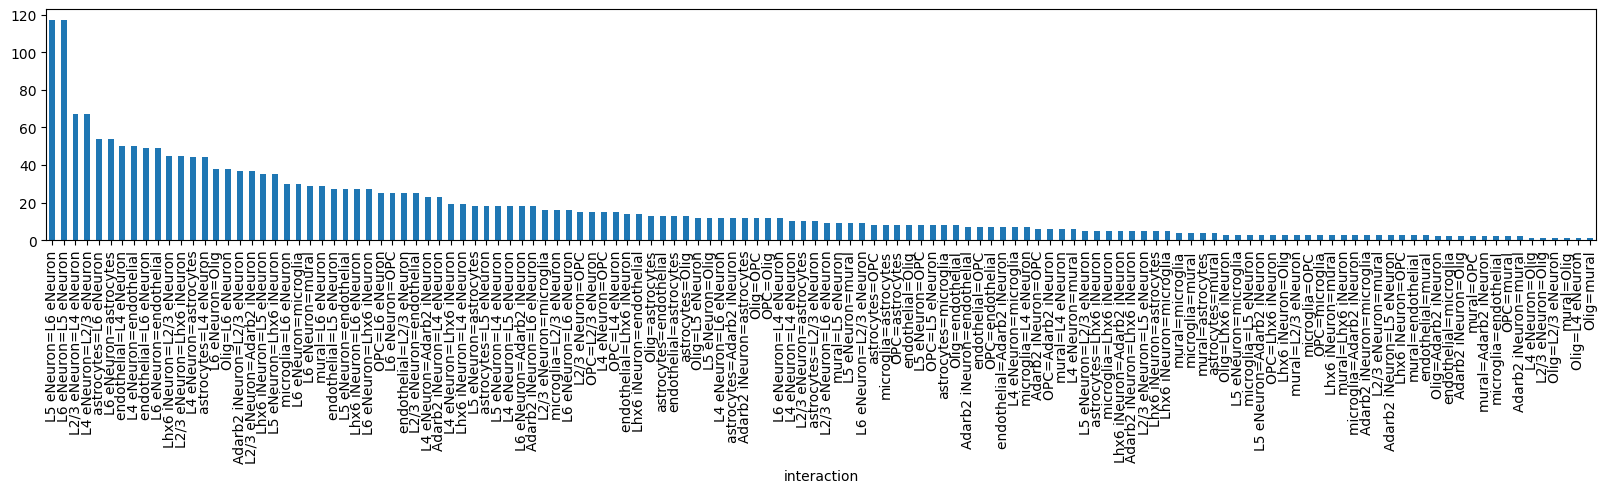

In [22]:
fig, ax = plt.subplots(1,1, figsize=(20,3))
int_edges_new.interaction.value_counts().plot(kind='bar',ax =ax)
#ax.axvline(x=)

In [20]:
focus_interactions = int_edges_new.interaction.value_counts()[
int_edges_new.interaction.value_counts() > 50
].index

In [25]:
int_edges_new.loc[int_edges_new.boundary_type == 'Internal']

,cell1,cell2,celltype1,celltype2,distance,boundary_type,interaction,self_loop
0,172,175,L4 eNeuron,L4 eNeuron,99.321750,Internal,L4 eNeuron=L4 eNeuron,False
1,175,172,L4 eNeuron,L4 eNeuron,99.321750,Internal,L4 eNeuron=L4 eNeuron,False
2,172,184,L4 eNeuron,L4 eNeuron,124.071955,Internal,L4 eNeuron=L4 eNeuron,False
3,184,172,L4 eNeuron,L4 eNeuron,124.071955,Internal,L4 eNeuron=L4 eNeuron,False
4,175,184,L4 eNeuron,L4 eNeuron,103.531348,Internal,L4 eNeuron=L4 eNeuron,False
5,184,175,L4 eNeuron,L4 eNeuron,103.531348,Internal,L4 eNeuron=L4 eNeuron,False
6,175,191,L4 eNeuron,L4 eNeuron,208.799090,Internal,L4 eNeuron=L4 eNeuron,False
7,191,175,L4 eNeuron,L4 eNeuron,208.799090,Internal,L4 eNeuron=L4 eNeuron,False
8,184,191,L4 eNeuron,L4 eNeuron,139.922836,Internal,L4 eNeuron=L4 eNeuron,False
9,191,184,L4 eNeuron,L4 eNeuron,139.922836,Internal,L4 eNeuron=L4 eNeuron,False


In [ ]:
int_edges_new.interaction

In [21]:
list(focus_interactions)

['L5 eNeuron=L6 eNeuron',
 'L6 eNeuron=L5 eNeuron',
 'L2/3 eNeuron=L4 eNeuron',
 'L4 eNeuron=L2/3 eNeuron',
 'astrocytes=L6 eNeuron',
 'L6 eNeuron=astrocytes']

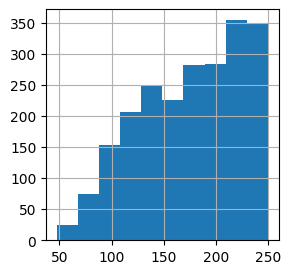

In [22]:
plt.figure(figsize=(3,3))
int_edges_new.distance.hist();

In [23]:
count_df = adata_sp.raw.to_adata().to_df()

In [24]:
sdm.extract_lr(adata_sp, 'mouse', min_cell=20)

In [25]:
data_list_dict, umi_sums, data_list_dict_close, umi_sums_close = \
spatial.prepare_data_list_for_other(
    count_df,
    int_edges_new,
    groups = list(focus_interactions),
    lig_rec_info_df=adata_sp.uns['geneInter'],
    heteromeric=True,
    lig_df=adata_sp.uns['ligand'],
    rec_df=adata_sp.uns['receptor'],
    summarization='sum',
    separate_lig_rec_type=True,
    close_contact_threshold=50
)

100%|██████████| 6/6 [00:15<00:00,  2.57s/it]


In [26]:
int_edges_new

,cell1,cell2,celltype1,celltype2,distance,boundary_type,interaction,self_loop
0,172,175,L4 eNeuron,L4 eNeuron,99.321750,Internal,L4 eNeuron=L4 eNeuron,False
1,175,172,L4 eNeuron,L4 eNeuron,99.321750,Internal,L4 eNeuron=L4 eNeuron,False
2,172,184,L4 eNeuron,L4 eNeuron,124.071955,Internal,L4 eNeuron=L4 eNeuron,False
3,184,172,L4 eNeuron,L4 eNeuron,124.071955,Internal,L4 eNeuron=L4 eNeuron,False
4,175,184,L4 eNeuron,L4 eNeuron,103.531348,Internal,L4 eNeuron=L4 eNeuron,False
...,...,...,...,...,...,...,...,...
2197,518,516,L6 eNeuron,L5 eNeuron,228.538208,External,L6 eNeuron=L5 eNeuron,False
2198,516,520,L5 eNeuron,L6 eNeuron,244.253099,External,L5 eNeuron=L6 eNeuron,False
2199,520,516,L6 eNeuron,L5 eNeuron,244.253099,External,L6 eNeuron=L5 eNeuron,False
2200,516,521,L5 eNeuron,L6 eNeuron,212.412990,External,L5 eNeuron=L6 eNeuron,False


In [27]:
data_list_dict.keys()

dict_keys(['L5 eNeuron=L6 eNeuron', 'L6 eNeuron=L5 eNeuron', 'L2/3 eNeuron=L4 eNeuron', 'L4 eNeuron=L2/3 eNeuron', 'astrocytes=L6 eNeuron', 'L6 eNeuron=astrocytes'])

In [69]:
def save_sdm_info(adata_obj, prefix):
    adata_obj.uns['ligand'].to_csv(prefix + '_ligand.csv')
    adata_obj.uns['receptor'].to_csv(prefix + '_receptor.csv')
    adata_obj.uns['geneInter'].to_csv(prefix + '_geneInter.csv')

In [70]:
save_sdm_info(adata_sp, 'seqfish_sdm')

In [28]:
lig_rec_info_df=adata_sp.uns['geneInter'].copy()
close_contact_index = []
other_index = []
for index,row in lig_rec_info_df.iterrows():
    if row.annotation == 'Cell-Cell Contact':
        close_contact_index += [index]
    else:
        other_index += [index]

In [29]:
def get_data(lig_rec_pair, gpair, cont_type='other'):
    if cont_type == 'other':
        o = np.array(other_index)
        index = np.where(o == lig_rec_pair)[0][0]
        x = data_list_dict[gpair][index][0]
        y = data_list_dict[gpair][index][1]
        us1 = umi_sums[gpair][gpair.split('=')[0]]
        us2 = umi_sums[gpair][gpair.split('=')[1]]
    else:
        o = np.array(close_contact_index)
        index = np.where(o == lig_rec_pair)[0][0]
        x = data_list_dict_close[gpair][index][0]
        y = data_list_dict_close[gpair][index][1]
        us1 = umi_sums_close[gpair][gpair.split('=')[0]]
        us2 = umi_sums_close[gpair][gpair.split('=')[1]]
    return (x, y, us1, us2)

In [31]:
copula_params = model2.CopulaParams()
opt_params = model2.OptParams()
cop_df_dict_distant = model2.run_copula(
    data_list_dict,
    umi_sums,
    groups = list(data_list_dict.keys()),
    df_lig_rec_index=other_index,
    n_jobs=20,
    heteronomic=True,
    copula_params=copula_params,
    opt_params=opt_params,
    stability_filter=True,
    quick=True,
    run_find_peaks = True
)

L5 eNeuron=L6 eNeuron


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    9.0s
[Parallel(n_jobs=20)]: Done 224 tasks      | elapsed:    9.7s
[Parallel(n_jobs=20)]: Done 1018 out of 1018 | elapsed:   10.9s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Number of non empty results: 994
L6 eNeuron=L5 eNeuron


[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.8s
[Parallel(n_jobs=20)]: Done 979 out of 1018 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=20)]: Done 1018 out of 1018 | elapsed:    1.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Number of non empty results: 1008
L2/3 eNeuron=L4 eNeuron


[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.8s
[Parallel(n_jobs=20)]: Done 979 out of 1018 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=20)]: Done 1018 out of 1018 | elapsed:    1.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Number of non empty results: 823
L4 eNeuron=L2/3 eNeuron


[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.8s
[Parallel(n_jobs=20)]: Done 1018 out of 1018 | elapsed:    1.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Number of non empty results: 815
astrocytes=L6 eNeuron


[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.7s
[Parallel(n_jobs=20)]: Done 1018 out of 1018 | elapsed:    1.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Number of non empty results: 597
L6 eNeuron=astrocytes


[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.7s


Number of non empty results: 708


[Parallel(n_jobs=20)]: Done 1018 out of 1018 | elapsed:    1.2s finished


In [32]:
import tqdm
from joblib import Parallel, delayed

In [184]:
importlib.reload(model2)

<module 'copulacci.model2' from '/n/fs/ragr-data/users/hirak/environments/mambaforge/envs/copulacci/lib/python3.9/site-packages/copulacci/model2.py'>

In [33]:
data_list_dict.keys()

dict_keys(['L5 eNeuron=L6 eNeuron', 'L6 eNeuron=L5 eNeuron', 'L2/3 eNeuron=L4 eNeuron', 'L4 eNeuron=L2/3 eNeuron', 'astrocytes=L6 eNeuron', 'L6 eNeuron=astrocytes'])

In [35]:
ligand_df = adata_sp.uns['ligand'].copy()
receptor_df = adata_sp.uns['receptor'].copy()

bg_data_dict = {}
for gpair in ['L6 eNeuron=L5 eNeuron']:
    copula_df = cop_df_dict_distant[gpair].copy()
    lig_rec_index = copula_df.loc[copula_df.copula_method == 'copula'].index.tolist()
    bg_permutation_data = model2.graph_permutation_pval(
        count_df,
        int_edges_with_selfloop,
        lig_rec_index=lig_rec_index,
        lig_df=ligand_df,
        rec_df=receptor_df,
        groups=[gpair],
        close_group=close_contact_index,
        heteromeric=True,
        n = 500,
        summarization='sum',
        n_jobs=20,
        verbose=0,
        opt_params=opt_params,
        stability_filter=True,
        quick=True,
        run_find_peaks = True
    )
    bg_data_dict[gpair] = bg_permutation_data[gpair].copy()

Constructing 500 random graphs with 112 nodes and 117 edges
Time taken to construct 500 random graphs: 2.98 seconds


100%|██████████| 1008/1008 [30:04<00:00,  1.79s/it]


In [36]:
gpair = 'L6 eNeuron=L5 eNeuron'

In [59]:
bg_data_dict.keys()

dict_keys(['L6 eNeuron=L5 eNeuron'])

In [39]:
def add_pvalue(row):
    if row.name in bg_permutation_dict:
        bg = bg_permutation_dict[row.name]
        if len(bg) < 100:
            return 1.0
        I = row.copula_coeff
        bg = np.append(bg, I)
        pval = np.sum(abs(bg) > abs(I))/len(bg)
        return pval
    return 1.0

In [40]:
def draw_background(
    lr_index, 
    copula_df,
    bg_permutation_dict
):
    I = copula_df.loc[lr_index, 'copula_coeff']
    bg = bg_permutation_dict[lr_index]
    if not ('copula_pval' in copula_df.columns):
        bg_I = np.append(bg, I)
        pval = np.sum(abs(bg_I) > abs(I))/len(bg_I)
    else:
        pval = copula_df.loc[lr_index, 'copula_pval']
    plt.figure(figsize=(3,3))
    plt.hist(bg,alpha = 0.8);
    plt.axvline(I, c='r', ls = '--')
    plt.title(f"{lr_index} - Pvalue {pval:.3f}")
    plt.show()

In [41]:
copula_df['copula_pval'] = copula_df.apply(lambda row: add_pvalue(row), axis=1)

In [44]:
copula_df = copula_df.reset_index().rename(columns = {'index' : 'LR_index'})

In [45]:
adata_scc = adata_sp.copy()
scc_df_dict = model2.run_scc(
    adata_scc,
    adata_sp.uns['geneInter'],
    int_edges_new,
    groups=[gpair],
    lig_df=adata_sp.uns['ligand'],
    rec_df=adata_sp.uns['receptor'],
    n_jobs=20,
    verbose=1,
    heteronomic=True,
    add_pval=True,
    use_spatialdm=True
)

L6 eNeuron=L5 eNeuron


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    9.6s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:   11.5s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:   13.8s
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:   17.1s
[Parallel(n_jobs=20)]: Done 1018 out of 1018 | elapsed:   19.5s finished


In [119]:
!pwd

/n/fs/ragr-research/users/hirak/Projects/niche_project/COMMOT_paper_data/seqfishplus-mouse-sscortex


In [106]:
importlib.reload(model)

<module 'copulacci.model' from '/n/fs/ragr-data/users/hirak/environments/mambaforge/envs/copulacci/lib/python3.9/site-packages/copulacci/model.py'>

In [46]:
sdm_df_dict = model.run_sdm(
    adata_sp,
    int_edges_new,
    species="mouse",
    groups = [gpair],
    nproc = 20,
    heteronomic=True
)

L6 eNeuron=L5 eNeuron
DiGraph with 112 nodes and 117 edges
(112, 10000)
time taken for  L6 eNeuron=L5 eNeuron  is  28.12525200843811  seconds


In [108]:
copula_df.head()

,copula_coeff,mu_x,mu_y,copula_method,interaction,LR_index
0,0.009262,-9.799605,-8.801121,copula,L5 eNeuron=L6 eNeuron,COL6A5_ITGA9_ITGB1
1,0.104941,-9.710151,-8.803859,copula,L5 eNeuron=L6 eNeuron,COL4A3_ITGA9_ITGB1
2,-0.028064,-8.765127,-8.800880,copula,L5 eNeuron=L6 eNeuron,COL6A1_ITGA9_ITGB1
3,-0.140145,-9.560450,-8.790983,copula,L5 eNeuron=L6 eNeuron,COL4A4_ITGA9_ITGB1
4,-0.027599,-9.342866,-8.799721,copula,L5 eNeuron=L6 eNeuron,COL4A6_ITGA9_ITGB1


In [199]:
merged_res = {}
for gpair in data_list_dict.keys():
    tmp1 = scc_df_dict[gpair].copy()
    tmp2 = sdm_df_dict[gpair].copy()
    tmp3 = tmp1.join(tmp2[['global_I', 'global_pval']], how='inner')
    tmp4 = copula_df.loc[
        copula_df.interaction==gpair
    ].copy()
    tmp5 = tmp4.set_index('LR_index').join(tmp3, how='inner')
    merged_res[gpair] = tmp5.copy()

In [47]:
tmp1 = scc_df_dict[gpair].copy()
tmp2 = sdm_df_dict[gpair].copy()
tmp3 = tmp1.join(tmp2[['global_I', 'global_pval']], how='inner')

res = copula_df.set_index('LR_index').join(tmp3, how='inner')

In [49]:
import itertools
score_pair = list(itertools.combinations(['copula_coeff', 'scc','global_I'],2))
from copulacci import plots2

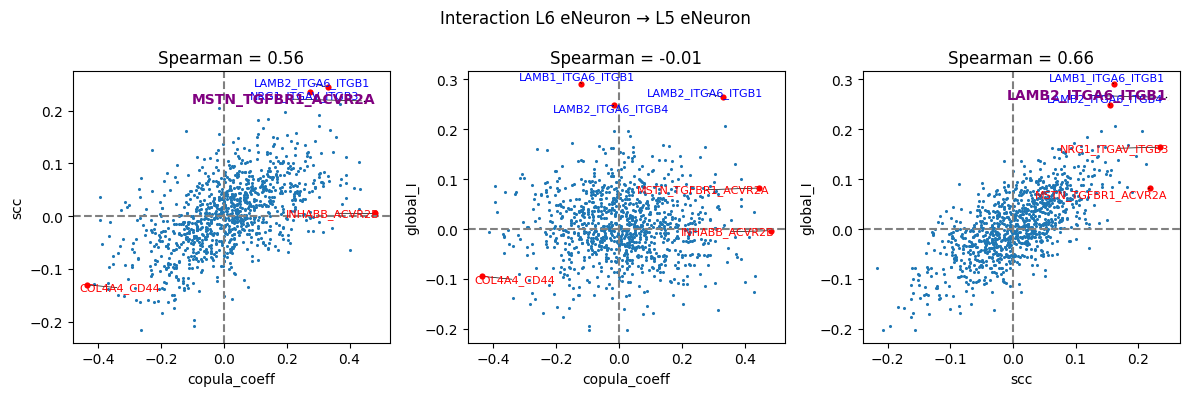

In [52]:
plots2.draw_pairwise_scatter(
    res,
      gpair,
      score_pair,
      bimod_filter=False,
    s = 5,
    ntop=3,
    center_plot=False
    #only_pos=True
)

In [54]:
from statsmodels.stats.multitest import multipletests

reject, pvals_corrected, _, _ = multipletests(res.copula_pval, alpha=0.05, method='fdr_bh')
res['copula_pval_fdr'] = pvals_corrected

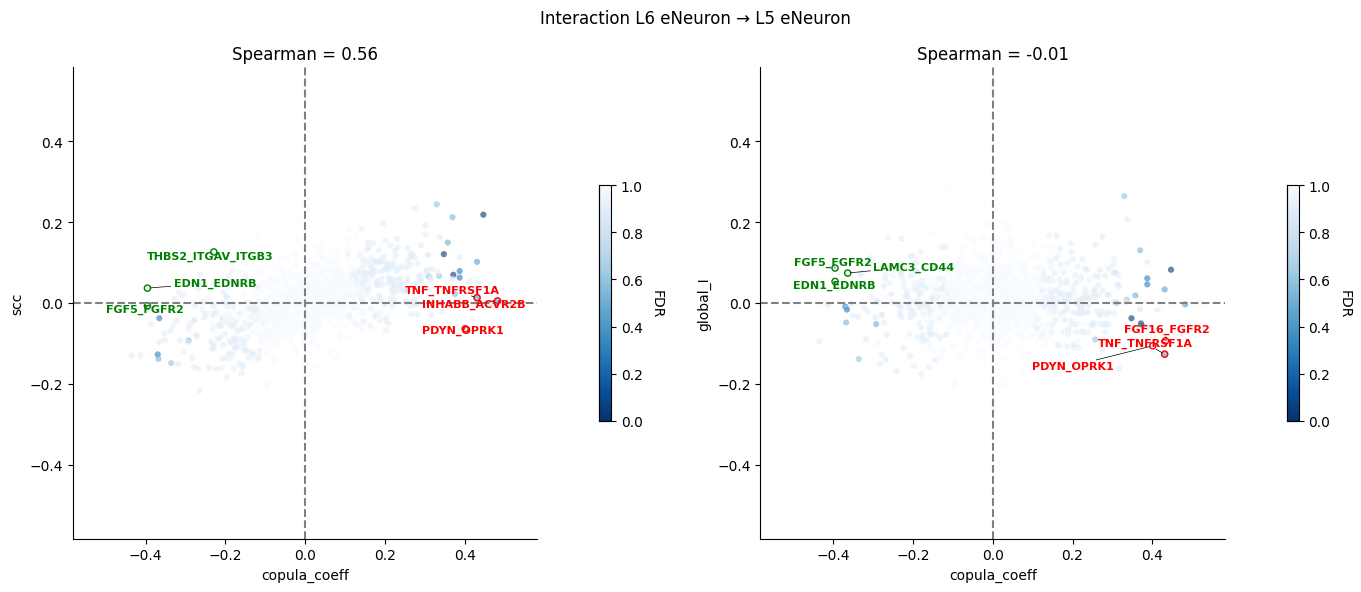

In [55]:
plots2.draw_pairwise_scatter_with_pval(
    res,
    gpair,
    score_pair[:2],
    ntop=3,
    center_plot=True,
    take_diff=True,
    fig_size = (14,6),
    force_text_pos=(1,0.1)
)

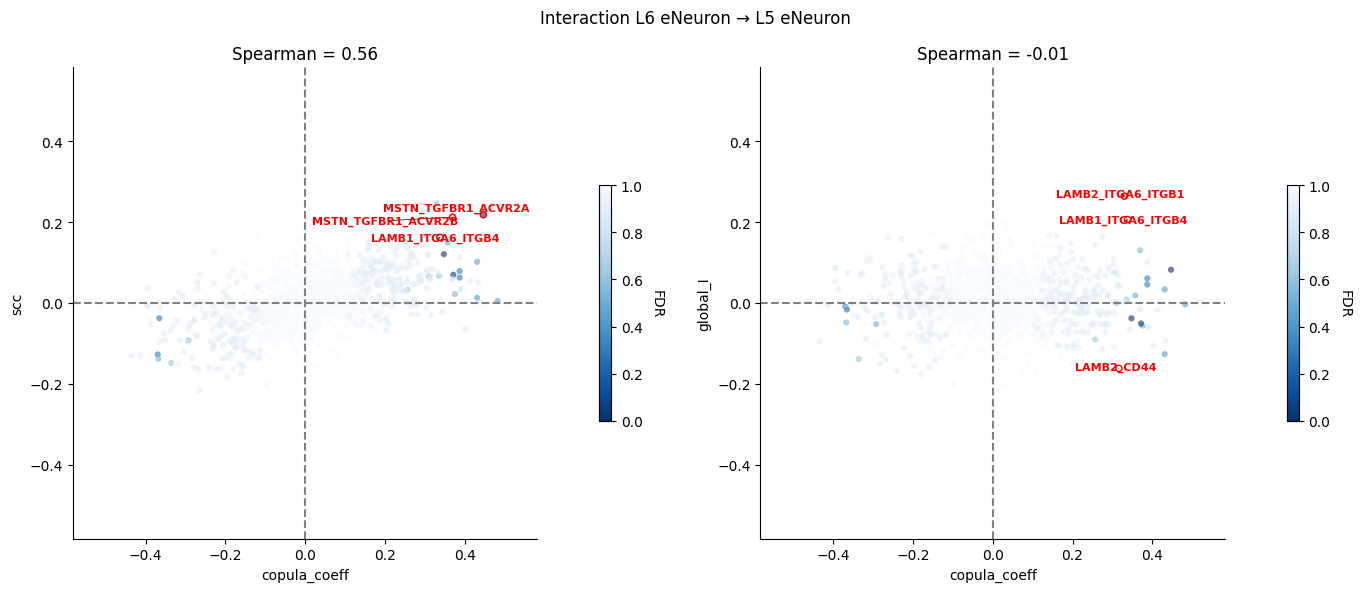

In [57]:
plots2.draw_pairwise_scatter_with_pval(
    res,
    gpair,
    score_pair[:2],
    ntop=3,
    center_plot=True,
    take_sim=True,
    fig_size = (14,6),
    force_text_pos=(1,0.1)
)

In [200]:
merged_res.keys()

dict_keys(['L5 eNeuron=L6 eNeuron', 'L6 eNeuron=L5 eNeuron', 'L2/3 eNeuron=L4 eNeuron', 'L4 eNeuron=L2/3 eNeuron', 'astrocytes=L6 eNeuron', 'L6 eNeuron=astrocytes'])

In [201]:
from copulacci import plots2

In [316]:
importlib.reload(plots2)

<module 'copulacci.plots2' from '/n/fs/ragr-data/users/hirak/environments/mambaforge/envs/copulacci/lib/python3.9/site-packages/copulacci/plots2.py'>

In [203]:
import itertools
score_pair = list(itertools.combinations(['copula_coeff', 'scc','global_I'],2))

In [210]:
merged_res.keys()

dict_keys(['L5 eNeuron=L6 eNeuron', 'L6 eNeuron=L5 eNeuron', 'L2/3 eNeuron=L4 eNeuron', 'L4 eNeuron=L2/3 eNeuron', 'astrocytes=L6 eNeuron', 'L6 eNeuron=astrocytes'])

In [444]:
res = merged_res['L2/3 eNeuron=L4 eNeuron'].copy()

In [445]:
res['diff'] = np.abs(res['copula_coeff'] - res['scc'])

In [446]:
res.head(2)

,copula_coeff,mu_x,mu_y,copula_method,interaction,scc,scc_pval,global_I,global_pval,diff
COL6A5_ITGA9_ITGB1,0.147545,-9.669667,-8.946472,copula,L2/3 eNeuron=L4 eNeuron,0.008325,0.946108,0.056036,1.007408e-10,0.139219
COL6A3_ITGA9_ITGB1,0.169286,-9.330165,-8.961889,copula,L2/3 eNeuron=L4 eNeuron,0.162188,0.127745,0.099804,3.196952e-31,0.007098


In [447]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource
output_notebook()

Loading BokehJS ...

In [448]:
res.to_csv('l6_l5.csv')

In [449]:
source = ColumnDataSource(data=dict(
    x=res.copula_coeff,
    y=res.scc,
    desc=res.index,
))
p = figure(title="Scatter plot for Copula vs SCC", x_axis_label='Copula', y_axis_label='SCC', tools="")
p.circle('x', 'y', size=5, source=source, color="navy", alpha=0.5)
hover = HoverTool()
hover.tooltips = [
    ("(copula,scc)", "($x, $y)"),
    ("LR_index", "@desc"),
]
p.add_tools(hover)

# Show the result
show(p)

In [269]:
tmp = res[['copula_coeff', 'scc']].copy()
tmp['Rank1'] = tmp['copula_coeff'].abs().rank(method='dense', ascending=False)
tmp['Rank2'] = tmp['scc'].abs().rank(method='dense', ascending=False)

In [308]:
x_col = 'copula_coeff'
y_col = 'scc'
ntop = 5
res = merged_res['L6 eNeuron=L5 eNeuron'].copy()
res['Rank1'] = res[x_col].abs().rank(method='dense', ascending=False)
res['Rank2'] = res[y_col].abs().rank(method='dense', ascending=False)
intersection_dict = {}
len_dict = {}
for i in range(res.shape[0]):
    lr_intersect = set(res.sort_values('Rank1').index[:i]).intersection(
        set(res.sort_values('Rank2').index[:i])
    )
    intersection_dict[i] = lr_intersect
    len_dict[len(lr_intersect)] = i
top_index_key = []
if ntop in len_dict:
    top_index_key = len_dict[ntop]
else:
    for k in len_dict:
        if k > ntop:
            top_index_key = len_dict[k]
            break
sig1 = res.loc[list(intersection_dict[top_index_key])].loc[res[x_col] > 0].copy()
sig2 = res.loc[list(intersection_dict[top_index_key])].loc[res[x_col] < 0].copy()

In [310]:
sig2

,copula_coeff,mu_x,mu_y,copula_method,interaction,scc,scc_pval,global_I,global_pval,Rank1,Rank2
TRH_TRHR2,-0.322531,-9.545374,-9.915335,copula,L6 eNeuron=L5 eNeuron,-0.151126,0.007984,-0.134715,1.0,36.0,29.0
ANGPTL2_ITGA5_ITGB1,-0.342794,-9.639118,-9.458689,copula,L6 eNeuron=L5 eNeuron,-0.148555,0.045908,-0.106187,1.0,28.0,34.0


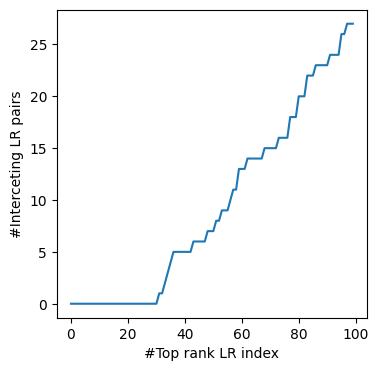

In [274]:
intersection = np.array(intersection)
plt.figure(figsize=(4,4))
plt.plot(intersection[:,0], intersection[:,1]);
plt.xlabel('#Top rank LR index')
plt.ylabel('#Interceting LR pairs');

In [285]:
top_index_key = intersection_dict[42]

In [292]:
res.loc[list(top_index_key)].loc[res['copula_coeff'] > 0]

,copula_coeff,mu_x,mu_y,copula_method,interaction,scc,scc_pval,global_I,global_pval,diff
LAMB2_ITGA6_ITGB1,0.328640,-9.833939,-9.293455,copula,L6 eNeuron=L5 eNeuron,0.243698,0.003992,0.191365,2.449523e-294,0.084942
LAMB1_ITGA6_ITGB4,0.337898,-9.939835,-8.921093,copula,L6 eNeuron=L5 eNeuron,0.162220,0.015968,0.067131,1.175951e-37,0.175678
WNT16_FZD4_LRP5,0.358369,-9.413962,-8.943886,copula,L6 eNeuron=L5 eNeuron,0.149396,0.035928,0.029063,3.512128e-08,0.208972


In [313]:
res.loc[list(intersection_dict[34])]

,copula_coeff,mu_x,mu_y,copula_method,interaction,scc,scc_pval,global_I,global_pval,Rank1,Rank2
ANGPTL2_ITGA5_ITGB1,-0.342794,-9.639118,-9.458689,copula,L6 eNeuron=L5 eNeuron,-0.148555,0.045908,-0.106187,1.000000e+00,28.0,34.0
WNT16_FZD4_LRP5,0.358369,-9.413962,-8.943886,copula,L6 eNeuron=L5 eNeuron,0.149396,0.035928,0.029063,3.512128e-08,25.0,33.0
LAMB1_ITGA6_ITGB4,0.337898,-9.939835,-8.921093,copula,L6 eNeuron=L5 eNeuron,0.162220,0.015968,0.067131,1.175951e-37,31.0,16.0


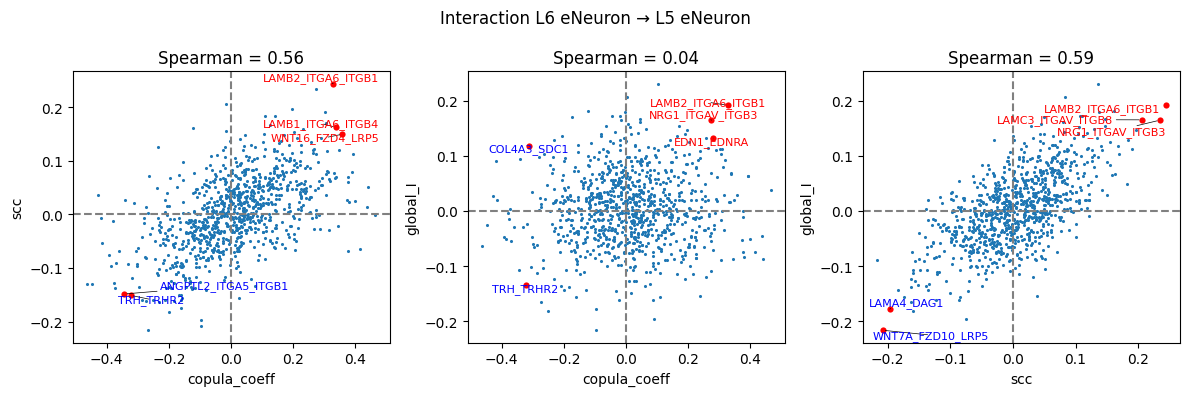

In [317]:
plots2.draw_pairwise_scatter(
          merged_res,
          'L6 eNeuron=L5 eNeuron',
          score_pair,
          bimod_filter=False,
        s = 5,
        ntop=5,
        take_sim=True
        #only_pos=True
    )

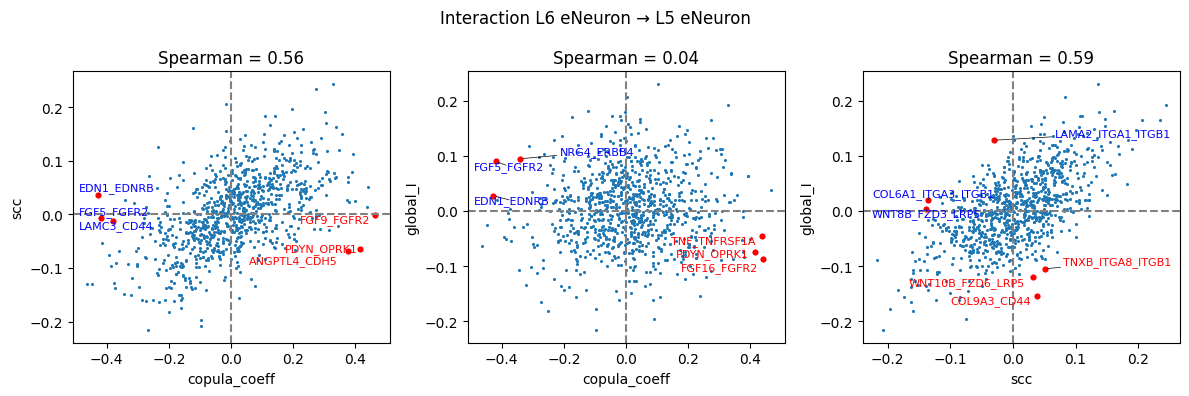

In [226]:
plots2.draw_pairwise_scatter(
          merged_res,
          'L6 eNeuron=L5 eNeuron',
          score_pair,
          bimod_filter=False,
        s = 5,
        ntop=3,
        take_diff=True
        #only_pos=True
    )

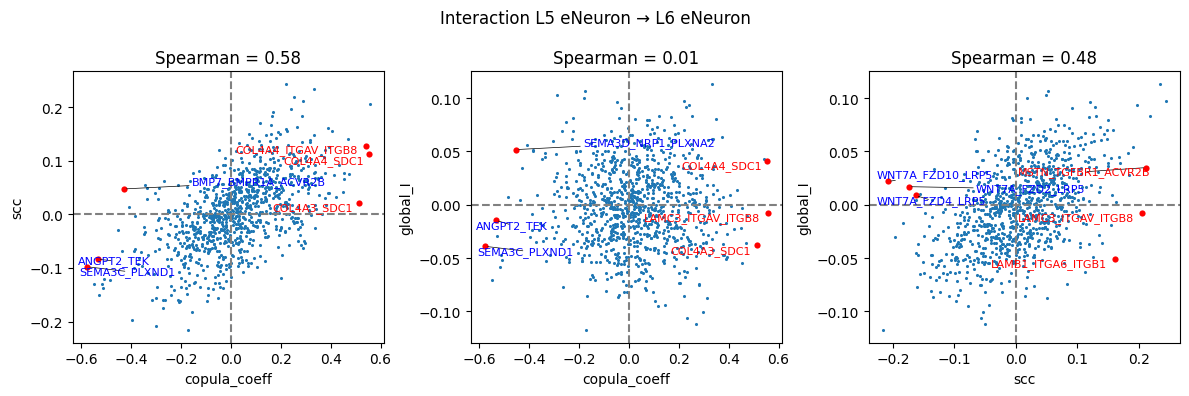

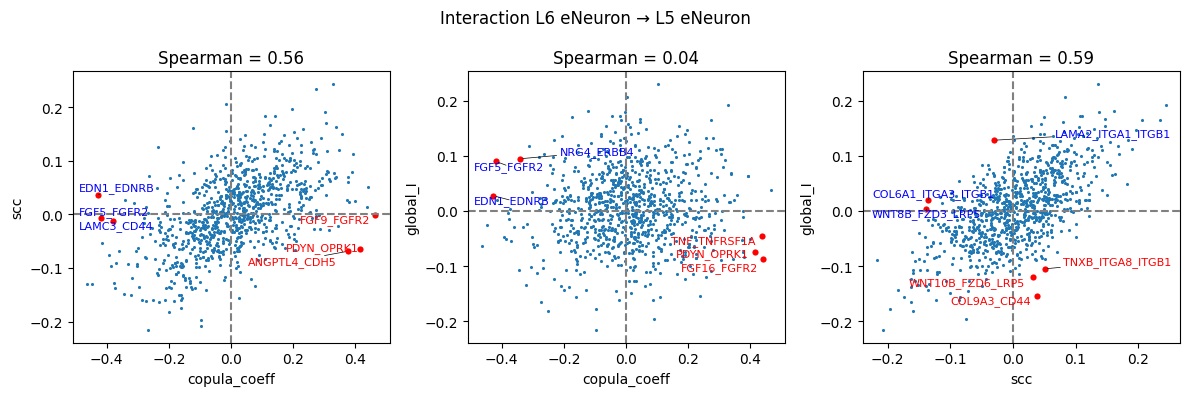

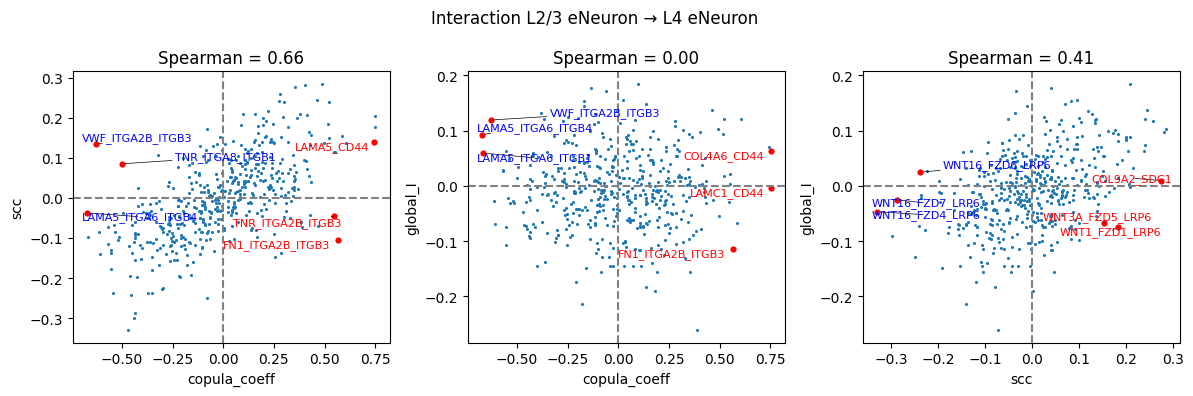

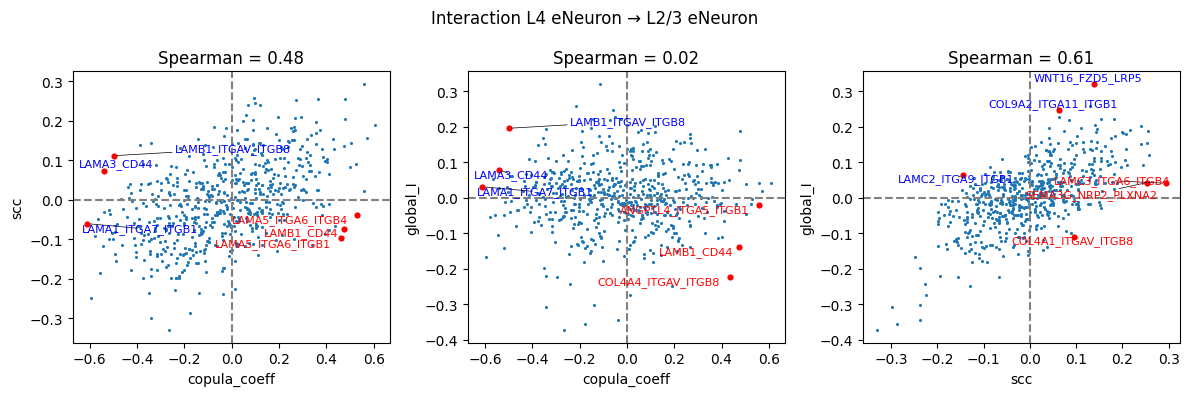

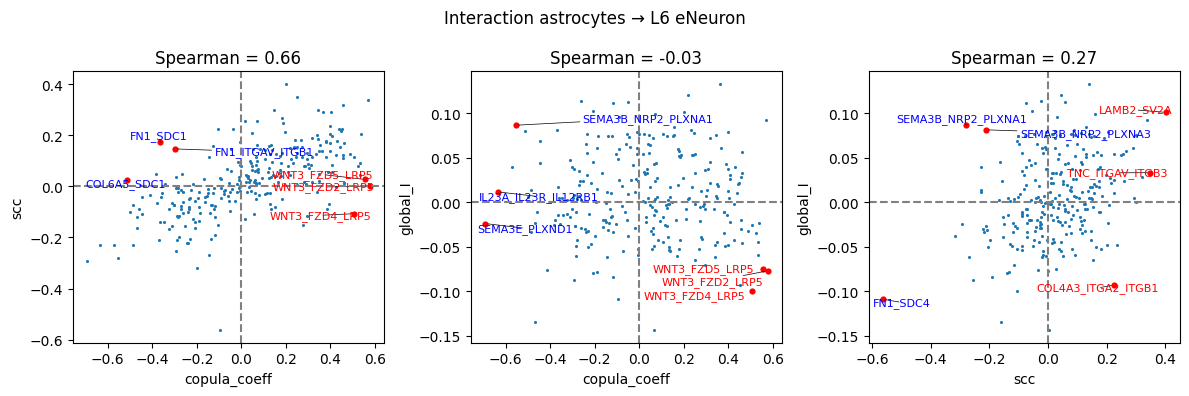

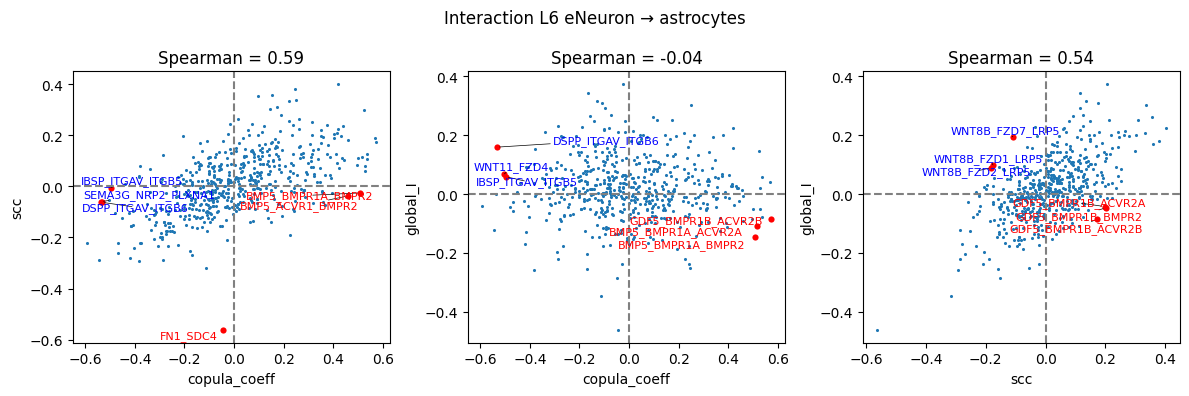

In [204]:
for gpair in list(data_list_dict.keys()):
    plots2.draw_pairwise_scatter(
          merged_res,
          gpair,
          score_pair,
          bimod_filter=False,
        s = 5,
        ntop=3,
        take_diff=True
        #only_pos=True
    )

In [122]:
importlib.reload(plots2)

<module 'copulacci.plots2' from '/n/fs/ragr-data/users/hirak/environments/mambaforge/envs/copulacci/lib/python3.9/site-packages/copulacci/plots2.py'>

In [123]:
loc_df = plots2.get_loc_df(adata_sp)

In [432]:
count_df_norm = count_df.div(count_df.sum(1), axis = 0) 
count_df_norm_log = np.log( count_df_norm + 1 )

In [490]:
from matplotlib.colors import Normalize
def plot_norm_lr_boundary_in_same_plot(
    gpair,
    lr_index,
    loc_df,
    int_edges_new,
    gene1,
    gene2,
    count_df,
    merged_res,
    shrink_fraction=1.0,
    file_name = None,
    figsize = (7,5),
    markersize = 10,
    cont_type = 'other',
    copula_params=model2.CopulaParams()
):
    int_type = gpair
    lr_pairs_ct = int_edges_new.loc[
            int_edges_new.interaction == int_type,
            :
    ].copy()

    tmp = loc_df
    tmp = tmp.loc[
        list(set(lr_pairs_ct.cell1).union(lr_pairs_ct.cell2).intersection(tmp.index)),
        :
    ]

    x, y, us1, us2 = get_data(lr_index, gpair, cont_type=cont_type)
    copula_params = copula_params._replace(return_sum=False)
    sx = np.log(x.sum() / us1.sum())
    sy = np.log(y.sum() / us2.sum())
    res = merged_res[gpair].copy()
    coeff = res.loc[lr_index].copula_coeff
    loglikvec = model2.calculate_mahalanobis_distance(
        [coeff, sx, sy],
        x,
        y,
        us1,
        us2,
        copula_params
    )
    lr_pairs_ct['copula_score'] = loglikvec
    
    selected_cells_1 = list(set(lr_pairs_ct.cell1).intersection(set(tmp.index)))
    selected_cells_2 = list(set(lr_pairs_ct.cell2).intersection(set(tmp.index)))

    max_gene1 = count_df.loc[selected_cells_1, gene1].values.max()
    max_gene2 = count_df.loc[selected_cells_2, gene2].values.max()
    global_max = max(max_gene1, max_gene2)
    global_min = min(
        count_df.loc[selected_cells_1, gene1].values.min(),
        count_df.loc[selected_cells_2, gene2].values.min()
    )
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    ax.scatter(loc_df['x'], loc_df['y'], c= "grey", s=0.4,alpha = 0.4)
    colors = np.array(count_df.loc[selected_cells_1, gene1].values)
    tmp = loc_df.loc[selected_cells_1,:].copy()
    tmp.loc[:, 'gene'] = colors
    sns.scatterplot(x='x', y='y', hue='gene',
                     palette='Reds',s=markersize, data=tmp,edgecolor='black',alpha=1,ax= ax)
    norm = Normalize(tmp['gene'].min(), tmp['gene'].max())
    #norm = Normalize(global_min, global_max)
    sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)
    sm.set_array([])
    ax.get_legend().remove()
    cax = ax.figure.colorbar(sm,ax=ax,shrink=shrink_fraction,pad=-0.1)
    cax.set_label(gene1, color='red', rotation=270, labelpad=15)
    
    colors = np.array(count_df.loc[selected_cells_2, gene2].values)
    tmp = loc_df.loc[selected_cells_2,:].copy()
    tmp.loc[:, 'gene'] = colors
    sns.scatterplot(x='x', y='y', hue='gene',marker="^",
                     palette='Blues',s=markersize, data=tmp,edgecolor='black',alpha=1,ax= ax)
    norm = Normalize(tmp['gene'].min(), tmp['gene'].max())
    #norm = Normalize(global_min, global_max)
    sm = plt.cm.ScalarMappable(cmap="Blues", norm=norm)
    sm.set_array([])
    ax.get_legend().remove()
    ax.set_title(f"{lr_index} - copula: {coeff:.2f} \n {gpair}")
    #ax.set_title(gene1 + " | " + gene2 + "\n" + gpair)
    cax = ax.figure.colorbar(sm,ax=ax,shrink=shrink_fraction, pad=-0.1)
    cax.set_label(gene2, color='blue', rotation=270, labelpad=15)


    # draw edges
    norm = Normalize(vmin=min(lr_pairs_ct.copula_score), 
                     vmax=np.quantile(lr_pairs_ct.copula_score, 0.95))
    cmap = plt.get_cmap('Greys')
    for ind,row in lr_pairs_ct.iterrows():
        x1, y1 = loc_df.loc[  row.cell1, 'x' ], loc_df.loc[  row.cell1, 'y' ]
        x2, y2 = loc_df.loc[  row.cell2, 'x' ], loc_df.loc[  row.cell2, 'y' ]
        dx = x2 - x1
        dy = y2 - y1
        color = cmap(norm(row.copula_score))
        # ax.plot([x1, x2], [y1, y2], color='black',
        #         linestyle='-', markersize=0.5,linewidth=0.3)
        ax.quiver(np.array([x1]), np.array([y1]), 
                  np.array([dx]), np.array([dy]),
                  angles='xy', scale_units='xy',
                  color=color,
                  scale=1, 
                  headwidth=10,
                  headaxislength=5,
                  headlength=10,
                  width=0.001,
                 )
        # ax.arrow(x1, y1, dx, dy, head_width=0.05, 
        #          head_length=0.1, fc='k', ec='k')

    norm = Normalize(vmin=min(lr_pairs_ct.copula_score), 
                     vmax=np.quantile(lr_pairs_ct.copula_score,0.95))
    #norm = Normalize(global_min, global_max)
    sm = plt.cm.ScalarMappable(cmap="Greys", norm=norm)
    sm.set_array([])
    cax = ax.figure.colorbar(sm,ax=ax,shrink=shrink_fraction,pad=0)
    cax.set_label('mhl', color='blue', rotation=270, labelpad=15)
    
    ax.invert_yaxis()
    ax.set_xticks([])
    ax.set_yticks([]);
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.tight_layout()
    if file_name is not None:
        plt.savefig(os.path.join(figure_parent, file_name), format='pdf', dpi=500)
    plt.show()

In [382]:
list(data_list_dict.keys())

['L5 eNeuron=L6 eNeuron',
 'L6 eNeuron=L5 eNeuron',
 'L2/3 eNeuron=L4 eNeuron',
 'L4 eNeuron=L2/3 eNeuron',
 'astrocytes=L6 eNeuron',
 'L6 eNeuron=astrocytes']

In [370]:
res.head()

,copula_coeff,mu_x,mu_y,copula_method,interaction,scc,scc_pval,global_I,global_pval,Rank1,Rank2
COL6A5_ITGA9_ITGB1,0.019141,-9.546453,-9.341552,copula,L6 eNeuron=L5 eNeuron,-0.088384,0.247505,0.007953,1.360739e-01,808.0,169.0
COL4A3_ITGA9_ITGB1,0.029364,-9.858561,-9.341235,copula,L6 eNeuron=L5 eNeuron,0.065184,0.403194,0.097915,2.651008e-78,741.0,292.0
COL6A3_ITGA9_ITGB1,0.306128,-10.188564,-9.341729,copula,L6 eNeuron=L5 eNeuron,0.036519,0.654691,-0.089585,1.000000e+00,46.0,523.0
COL6A1_ITGA9_ITGB1,-0.181252,-8.902890,-9.326626,copula,L6 eNeuron=L5 eNeuron,-0.090354,0.231537,-0.036183,1.000000e+00,216.0,163.0
COL4A4_ITGA9_ITGB1,0.254055,-9.524621,-9.350262,copula,L6 eNeuron=L5 eNeuron,0.052166,0.500998,0.018683,4.124327e-04,92.0,392.0


In [371]:
x, y, us1, us2 = get_data('COL6A5_ITGA9_ITGB1', gpair, cont_type='other')

In [380]:
res.loc[lr_index].copula_coeff

0.41462102335628975

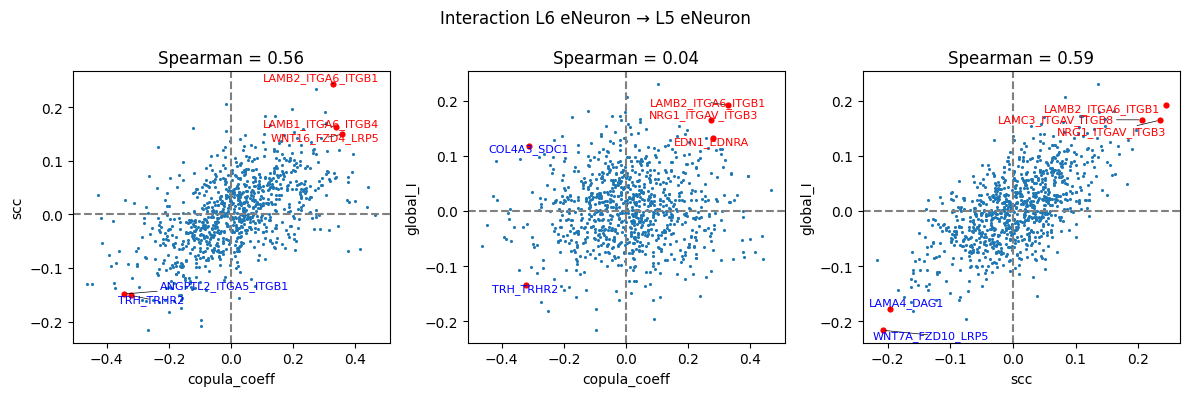

In [500]:
gpair = 'L6 eNeuron=L5 eNeuron'
plots2.draw_pairwise_scatter(
          merged_res,
          gpair,
          score_pair,
          bimod_filter=False,
        s = 5,
        ntop=5,
        #take_diff=True
        take_sim=True
        #only_pos=True
    )

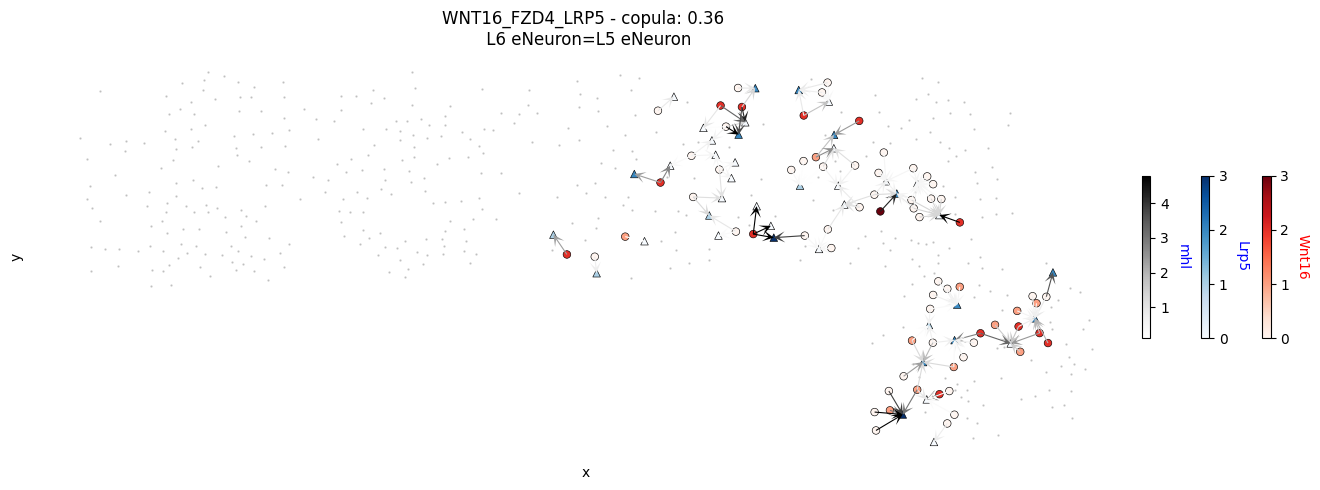

In [509]:
gpair = 'L6 eNeuron=L5 eNeuron'
lr_index = 'WNT16_FZD4_LRP5'
plot_norm_lr_boundary_in_same_plot(
    gpair,
    lr_index,
    loc_df,
    int_edges_new,
    gene1='Wnt16',
    gene2='Lrp5',
    count_df = count_df,
    merged_res=merged_res,
    shrink_fraction=0.4,
    markersize=30,
    figsize=(15,5)
#    file_name='BRCA_CXCL11_CXCR3_two_color.pdf'
)

In [455]:
 x, y, us1, us2 = get_data(lr_index, gpair, cont_type='other')
copula_params = copula_params._replace(return_sum=False)
sx = np.log(x.sum() / us1.sum())
sy = np.log(y.sum() / us2.sum())
coeff = res.loc[lr_index].copula_coeff
loglikvec = model2.calculate_mahalanobis_distance(
    [coeff, sx, sy],
    x,
    y,
    us1,
    us2,
    copula_params
)


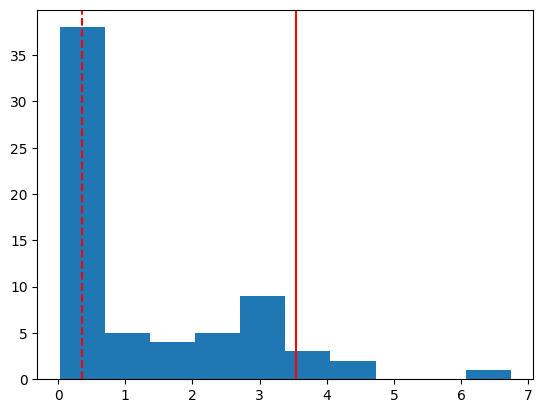

In [463]:
plt.hist(np.array(loglikvec));
plt.axvline(np.median(np.array(loglikvec)), color ='red', linestyle='--');
plt.axvline(np.quantile(np.array(loglikvec),0.95), color ='red');

In [387]:
importlib.reload(model2)

<module 'copulacci.model2' from '/n/fs/ragr-data/users/hirak/environments/mambaforge/envs/copulacci/lib/python3.9/site-packages/copulacci/model2.py'>

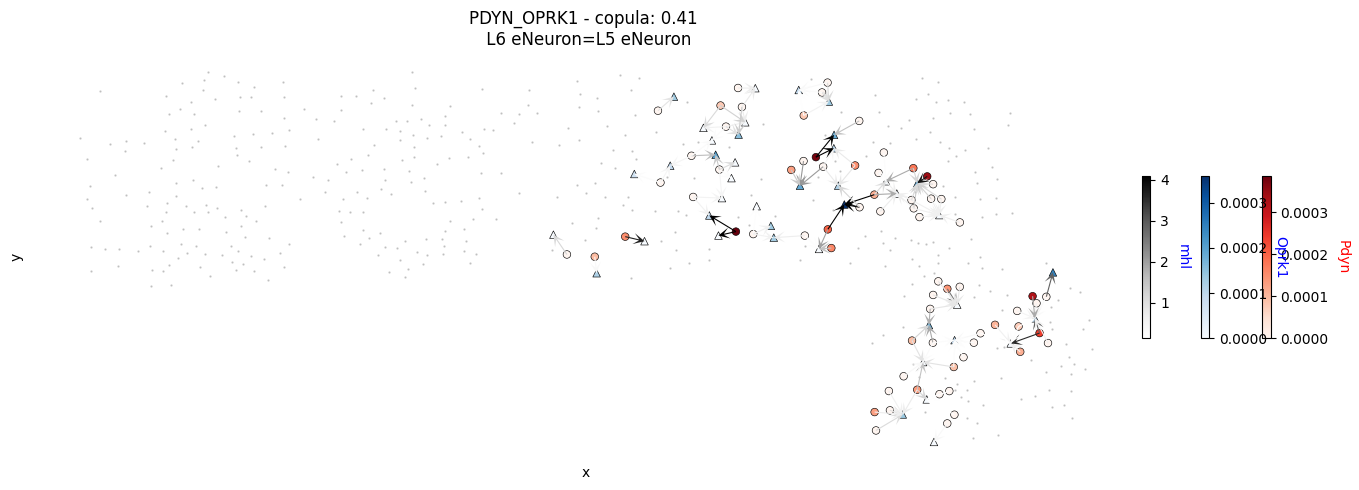

In [497]:
gpair = 'L6 eNeuron=L5 eNeuron'
lr_index = 'PDYN_OPRK1'
plot_norm_lr_boundary_in_same_plot(
    gpair,
    lr_index,
    loc_df,
    int_edges_new,
    gene1='Pdyn',
    gene2='Oprk1',
    count_df = count_df_norm,
    merged_res=merged_res,
    shrink_fraction=0.4,
    markersize=30,
    figsize=(15,5)
#    file_name='BRCA_CXCL11_CXCR3_two_color.pdf'
)

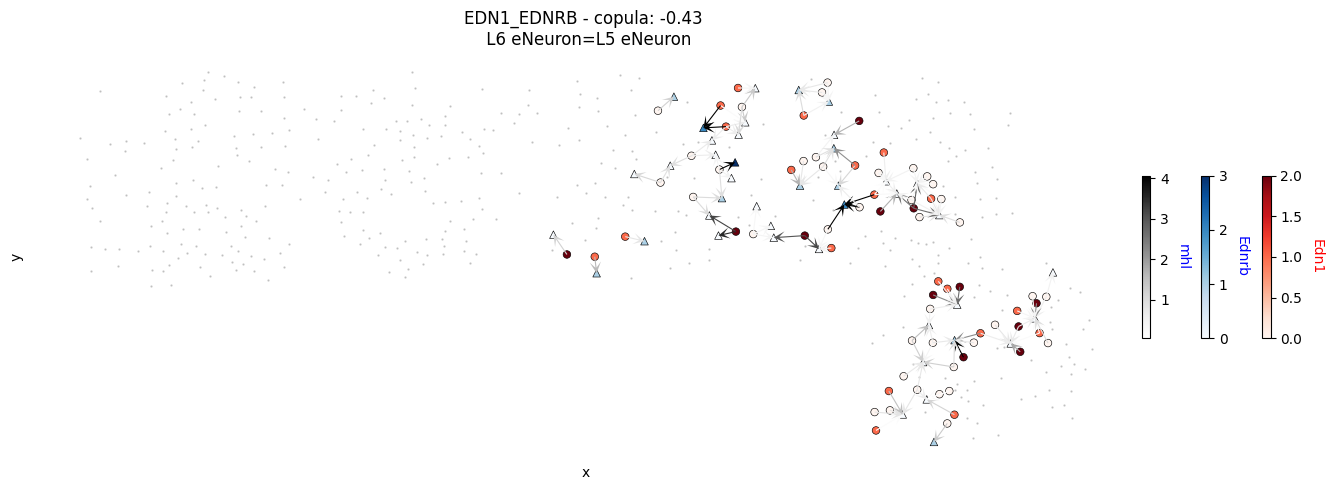

In [499]:
gpair = 'L6 eNeuron=L5 eNeuron'
lr_index = 'EDN1_EDNRB'
plot_norm_lr_boundary_in_same_plot(
    gpair,
    lr_index,
    loc_df,
    int_edges_new,
    gene1='Edn1',
    gene2='Ednrb',
    count_df = count_df,
     merged_res=merged_res,
    shrink_fraction=0.4,
    markersize=30,
    figsize=(15,5)
#    file_name='BRCA_CXCL11_CXCR3_two_color.pdf'
)

In [506]:
merged_res.keys()

dict_keys(['L5 eNeuron=L6 eNeuron', 'L6 eNeuron=L5 eNeuron', 'L2/3 eNeuron=L4 eNeuron', 'L4 eNeuron=L2/3 eNeuron', 'astrocytes=L6 eNeuron', 'L6 eNeuron=astrocytes'])

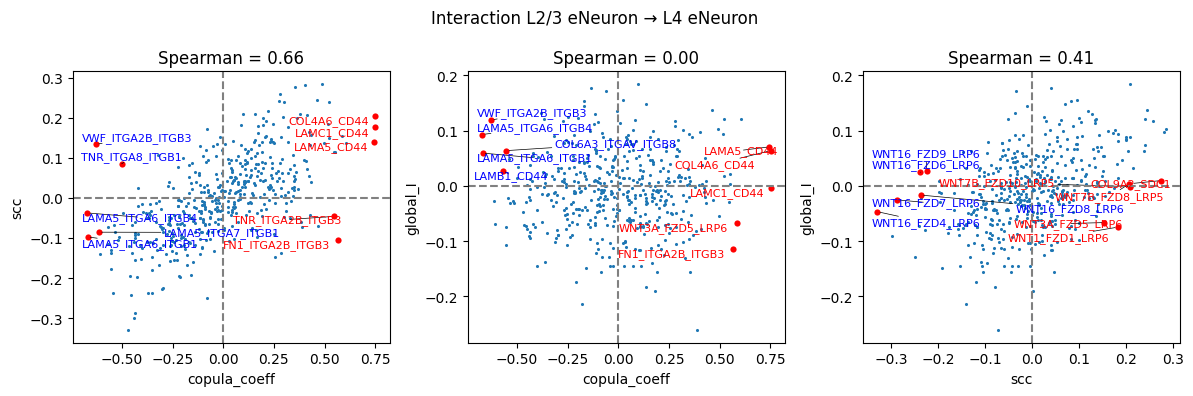

In [508]:
gpair = 'L2/3 eNeuron=L4 eNeuron'
plots2.draw_pairwise_scatter(
          merged_res,
          gpair,
          score_pair,
          bimod_filter=False,
        s = 5,
        ntop=5,
        take_diff=True
        #take_sim=True
        #only_pos=True
    )

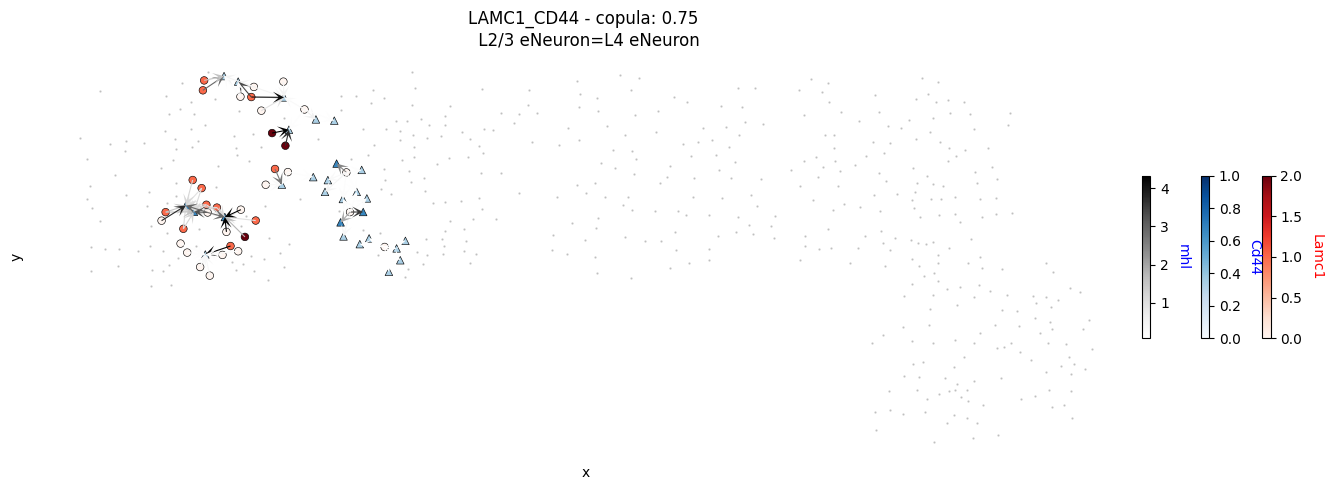

In [513]:
gpair = 'L2/3 eNeuron=L4 eNeuron'
lr_index = 'LAMC1_CD44'
plot_norm_lr_boundary_in_same_plot(
    gpair,
    lr_index,
    loc_df,
    int_edges_new,
    gene1='Lamc1',
    gene2='Cd44',
    count_df = count_df,
    merged_res=merged_res,
    shrink_fraction=0.4,
    markersize=30,
    figsize=(15,5)
#    file_name='BRCA_CXCL11_CXCR3_two_color.pdf'
)

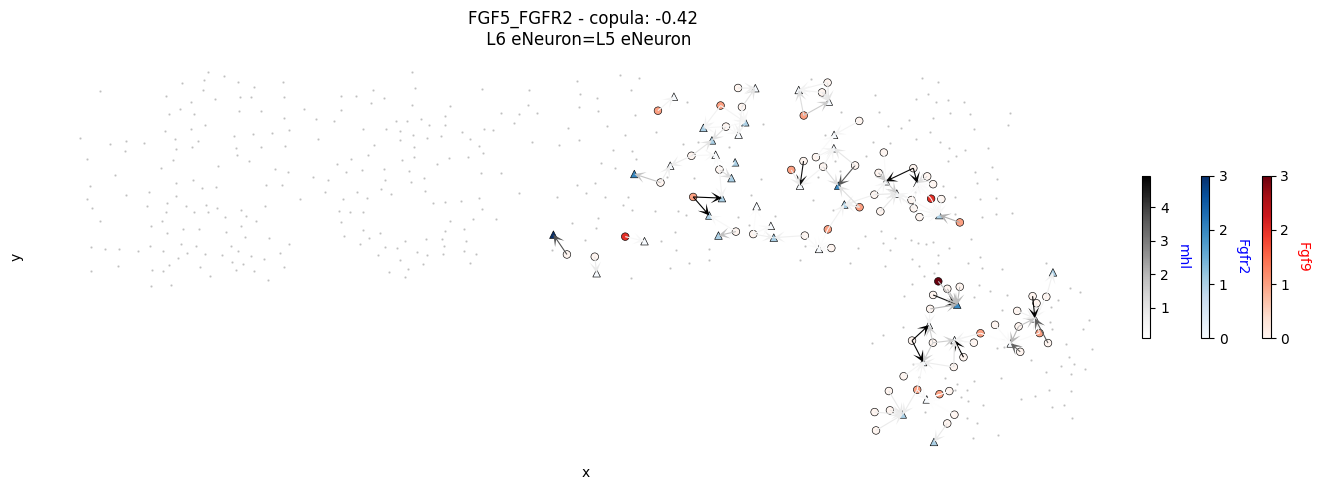

In [516]:
gpair = 'L6 eNeuron=L5 eNeuron'
lr_index = 'FGF5_FGFR2'
plot_norm_lr_boundary_in_same_plot(
    gpair,
    lr_index,
    loc_df,
    int_edges_new,
    gene1='Fgf9',
    gene2='Fgfr2',
    count_df = count_df,
     merged_res=merged_res,
    shrink_fraction=0.4,
    markersize=30,
    figsize=(15,5)
#    file_name='BRCA_CXCL11_CXCR3_two_color.pdf'
)

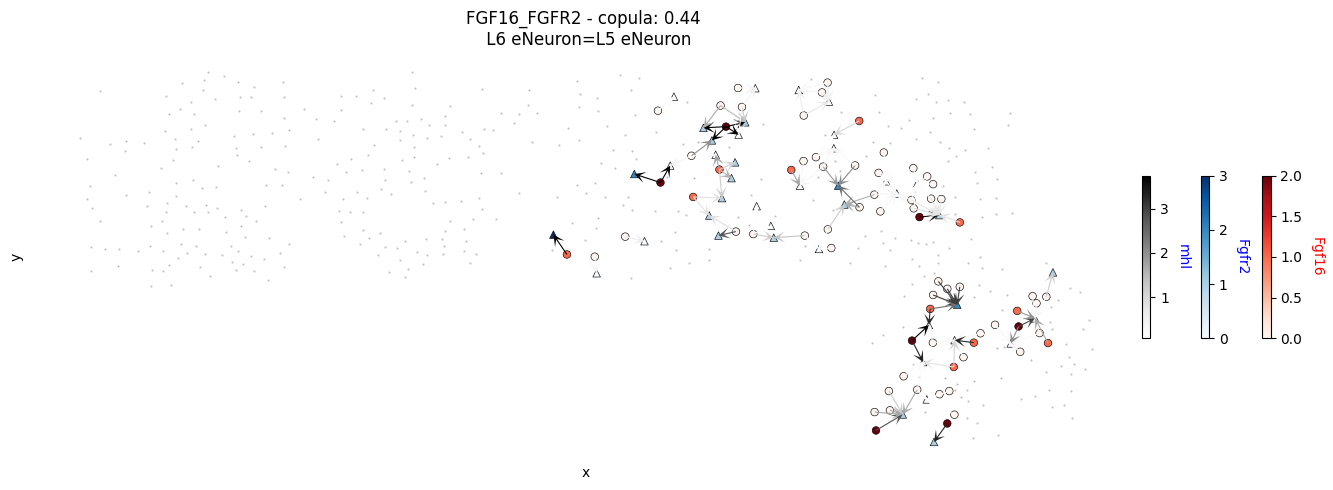

In [515]:
gpair = 'L6 eNeuron=L5 eNeuron'
lr_index = 'FGF16_FGFR2'
plot_norm_lr_boundary_in_same_plot(
    gpair,
    lr_index,
    loc_df,
    int_edges_new,
    gene1='Fgf16',
    gene2='Fgfr2',
    count_df = count_df,
     merged_res=merged_res,
    shrink_fraction=0.4,
    markersize=30,
    figsize=(15,5)
#    file_name='BRCA_CXCL11_CXCR3_two_color.pdf'
)

In [517]:
x, y, us1, us2 = get_data('FGF16_FGFR2', gpair, cont_type='other')

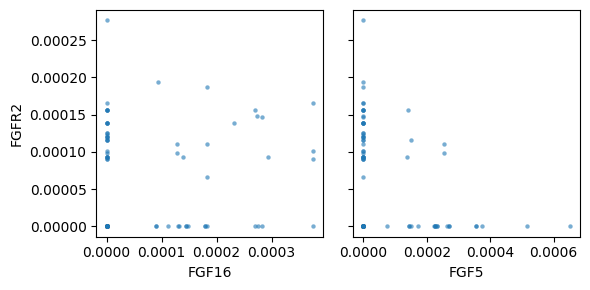

In [542]:
fig, ax = plt.subplots(1,2, figsize=(6,3),sharey=True)
x11, y12, us11, us12 = get_data('FGF16_FGFR2', gpair, cont_type='other')
ax[0].scatter(np.log(x11/us11+1), np.log(y12/us12+1),s=10,linewidth=0,alpha=0.6);
x21, y22, us21, us22 = get_data('FGF5_FGFR2', gpair, cont_type='other')
ax[1].scatter(np.log(x21/us21+1), np.log(y22/us22+1),s=10,linewidth=0,alpha=0.6);
ax[0].set_ylabel('FGFR2')
ax[0].set_xlabel('FGF16')
ax[1].set_xlabel('FGF5')
plt.tight_layout()

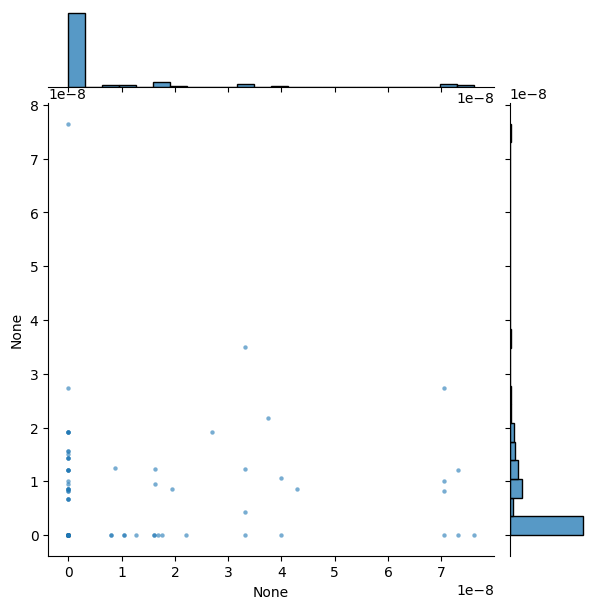

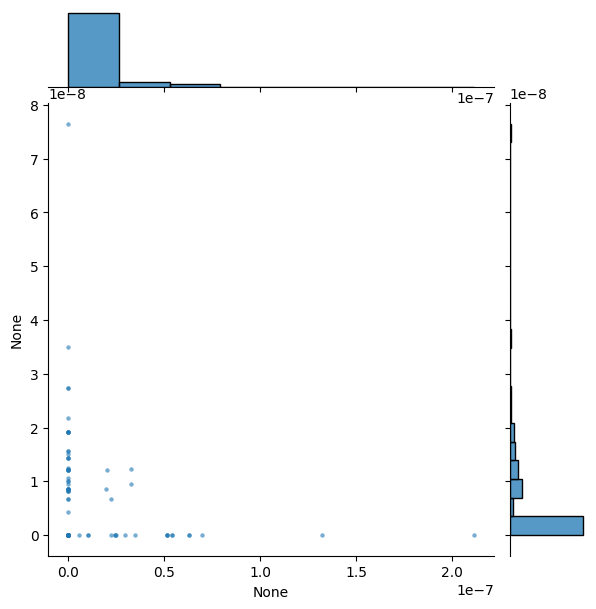

In [546]:

x11, y12, us11, us12 = get_data('FGF16_FGFR2', gpair, cont_type='other')
x11 = np.log(x11/us11 + 1)
y12 = np.log(y12/us12 + 1)
sns.jointplot(x=np.log(x11/us11+1), 
              y=np.log(y12/us12+1),s=10,
              linewidth=0,alpha=0.6,
              kind='scatter',ax=ax[0]);
x21, y22, us21, us22 = get_data('FGF5_FGFR2', gpair, cont_type='other')
x21 = np.log(x21/us21 + 1)
y22 = np.log(y22/us22 + 1)
sns.jointplot(x=np.log(x21/us21+1), 
              y=np.log(y22/us22+1),s=10,
              linewidth=0,alpha=0.6,
              kind='scatter',ax=ax[0]);

In [537]:
y22

array([0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 2, 0, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 1, 0, 3, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 2, 2, 0, 1, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 2, 2, 2, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1])